In [2]:
import os 
import json
import torch 
from tqdm import tqdm
import pandas as pd 
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from functions_models.usefull_function_model import *
from functions_models.models_archi import *
from functions_models.build_data_loader import build_data_loader

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
login = '/home/elabourdette'
dataset = "from_lov_maredat_made_2024"
training_name = f"lov_maredat_threshold_0.5"

In [12]:
import os
import torch

def run_model(image_size, num_model, pfts, login, dico, device='cpu', batch_size=1300):
    space_buffer = int(image_size / 2)
    max_latitude = int(image_size / 4)
    max_longitude = int(image_size / 4)
    date_buffer = 1
    threshold = 0.5

    # Chargement des données
    train_loader, valid_loader, test_loader, df_mini_cubes = build_data_loader(
        login, image_size, num_model, pfts, device, batch_size, dataset, 0.5
    )
    # Définition du chemin du modèle
    model_path = f'/home/elabourdette/complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process/training_{training_name}/model_{num_model}/space_buffer_{space_buffer}_date_buffer_1/'
    if space_buffer == 16 : 
                if num_model == 1 : 
                    if pfts: 
                        if threshold == 0.5:
                            num_training = 17
                            archi_model = f"pfts_[70,50]_lr_7x10e-4_d_0.1/train_{num_training}/MLP_1.pth"
                        elif threshold == 0.99 : 
                            num_training = 19
                            archi_model = f"pfts_[70,50]_lr_7x10e-4_d_0.1/train_{num_training}/MLP_1.pth"                        
                    else :
                        if threshold == 0.5:
                            num_training = 10
                            archi_model = f"tchla_[70]_lr_7x10e-4_d_0.05/train_{num_training}/MLP_1.pth"
                        elif threshold == 0.99 : 
                            num_training = 27
                            archi_model = f"tchla_[70]_lr_7x10e-4_d_0.05/train_{num_training}/MLP_1.pth"
                            
                elif num_model == 2 :
                    if pfts: 
                        if threshold == 0.5:
                            num_training = 30
                            archi_model = f"pfts_[70,50]_lr_7x10e-4_d_0.1/train_{num_training}/MLP_2.pth"
                        elif threshold == 0.99 : 
                            num_training = 17
                            archi_model = f"pfts_cnn_lr_7x10e-4/train_{num_training}/MLP_2.pth"                        
                    else :
                        if threshold == 0.5:
                            num_training = 9
                            archi_model = f"tchla_[70]_lr_7x10e-4_d_0.2/train_{num_training}/MLP_2.pth"
                        elif threshold == 0.99 : 
                            num_training = 29
                            archi_model = f"tchla_cnn_lr_7x10e-4/train_{num_training}/MLP_2.pth"
                            
    elif space_buffer == 50 : 
                if num_model == 1 : 
                    num_training = 6
                    archi_model = f"tchla_[70]/train_{num_training}/MLP_1.pth"
                elif num_model == 2 :
                    num_training = 12
                    archi_model = f"tchla_[100]_dropout_0.5/train_{num_training}/MLP_2.pth"
                elif num_model == 3 :
                    if pfts : 
                        num_training = 24
                        archi_model = f"pfts_cnn_lr_7x10e-4/train_{num_training}/CNN_2.pth"  
                    else : 
                        num_training = 14
                        archi_model = f"tchla_cnn_lr_7x10e-4/train_{num_training}/CNN_2.pth"
      
    model_path = os.path.join(model_path, archi_model)
    # Initialisation du modèle
    if space_buffer == 16 : 
        if num_model == 1:
            model_dl = DNN(6, [70], 1, device)
            if pfts:
                model_dl = DNN(6, [70, 50], 3, device)
        elif num_model == 2:
            model_dl = DNN(14, [100], 1, device)
            if pfts:
                model_dl = DNN(14, [100, 50], 3, device)
        elif num_model == 3:
            model_dl = ConvRegression(14, 1, 0.3)
            if pfts:
                model_dl = ConvRegression(14, 3, 0.3)
    elif space_buffer == 50 :
        if num_model == 1:
            model_dl = DNN(6, [70], 1, device)
            if pfts:
                model_dl = DNN(6, [70, 50], 3, device)
        elif num_model == 2:
            model_dl = DNN(14, [100], 1, device)
            if pfts:
                model_dl = DNN(14, [70, 50], 3, device)
        elif num_model == 3:
            model_dl = ConvRegression(14, 1, 0.3)
            if pfts:
                model_dl = ConvRegression(14, 3, 0.3)    

    # Chargement du modèle
    checkpoint = torch.load(model_path)
    model_dl.load_state_dict(checkpoint['model_state_dict'])
    model_dl.eval()
    model_dl.to(device)

    # Prédictions
    prediction_test = []
    true_test = []
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to(device)
            if num_model != 3:
                images[images == -10] = float('nan')
                images = images.nanmean(dim=(2, 3))
            outputs = model_dl(images.float())
            prediction_test.append(outputs.cpu())
            true_test.append(labels.cpu())

    prediction_test = torch.cat(prediction_test, dim=0)
    true_test = torch.cat(true_test, dim=0)

    # Post-traitement
    if pfts:
        predictions = {
            'micro': from_transfo_to_nn(prediction_test[:, 0], 1, dico["Micro_Chla_mean"], dico["Micro_Chla_std"]).flatten().tolist(),
            'nano': from_transfo_to_nn(prediction_test[:, 1], 1, dico["Nano_Chla_mean"], dico["Nano_Chla_std"]).flatten().tolist(),
            'pico': from_transfo_to_nn(prediction_test[:, 2], 1, dico["Pico_Chla_mean"], dico["Pico_Chla_std"]).flatten().tolist(),
        }
        truths = {
            'micro': from_transfo_to_nn(true_test[:, 0], 1, dico["Micro_Chla_mean"], dico["Micro_Chla_std"]).flatten().tolist(),
            'nano': from_transfo_to_nn(true_test[:, 1], 1, dico["Nano_Chla_mean"], dico["Nano_Chla_std"]).flatten().tolist(),
            'pico': from_transfo_to_nn(true_test[:, 2], 1, dico["Pico_Chla_mean"], dico["Pico_Chla_std"]).flatten().tolist(),
        }
        return truths, predictions, df_mini_cubes
    else:
        prediction_nn = from_transfo_to_nn(prediction_test, 1, dico["TChla_mean"], dico["TChla_std"]).flatten().tolist()
        true_nn = from_transfo_to_nn(true_test, 1, dico["TChla_mean"], dico["TChla_std"]).flatten().tolist()
        return true_nn, prediction_nn, df_mini_cubes


In [13]:
# ------------ 100 X 100 ------------ #
space_buffer = 50
path_dico = f"/home/elabourdette/complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process/dataset/from_lov_maredat_made_2024/threshold_0.5/space_buffer_{space_buffer}_date_buffer_1/dico_lambda_MLP.json"
with open(path_dico, 'r') as f:
    dico = json.load(f)
    
true_100cnn2, prediction_100cnn2, df_100 = run_model(100, 3, False, login, dico, device='cuda')
true_100cnn2_pfts, prediction_100cnn2_pfts, df_100_pfts = run_model(100, 3, True, login, dico, device='cuda')
prediction_tchla_100cnn2_pfts = np.array(prediction_100cnn2_pfts['micro']) + np.array(prediction_100cnn2_pfts['nano']) + np.array(prediction_100cnn2_pfts['pico'])

#true_100mlp2, prediction_100mlp2, df_100 = run_model(100, 2, False, login, dico, device='cuda')
#true_100mlp2_pfts, prediction_100mlp2_pfts, df_100_pfts = run_model(100, 2, True, login, dico, device='cuda')
#prediction_tchla_100mlp2_pfts = np.array(prediction_100mlp2_pfts['micro']) + np.array(prediction_100mlp2_pfts['nano']) + np.array(prediction_100mlp2_pfts['pico'])

#true_100mlp1, prediction_100mlp1, df_100_pfts = run_model(100, 1, False, login, dico, device='cuda')
#true_100mlp1_pfts, prediction_100mlp1_pfts, df_100_pfts = run_model(100, 1, True, login, dico, device='cuda')
#prediction_tchla_100mlp1_pfts = np.array(prediction_100mlp1_pfts['micro']) + np.array(prediction_100mlp1_pfts['nano']) + np.array(prediction_100mlp1_pfts['pico'])

diff_100cnn2 = np.array(true_100cnn2) - np.array(prediction_100cnn2)
#diff_100mlp2 = np.array(true_100mlp2) - np.array(prediction_100mlp2)
#diff_100mlp1 = np.array(true_100mlp1) - np.array(prediction_100mlp1)

diff_100cnn2_pfts = true_100cnn2 - prediction_tchla_100cnn2_pfts
#diff_100mlp2_pfts = true_100mlp2 - prediction_tchla_100mlp2_pfts 
#diff_100mlp1_pfts = true_100mlp1 - prediction_tchla_100mlp1_pfts 

# ------------ 32 X 32 ------------ #
space_buffer = 16
path_dico = f"/home/elabourdette/complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process/dataset/from_lov_maredat_made_2024/space_buffer_{space_buffer}_date_buffer_1/dico_lambda_MLP.json"
with open(path_dico, 'r') as f:
    dico = json.load(f)

true_32mlp2_pfts, prediction_32mlp2_pfts, df_32_pfts = run_model(32, 2, True, login, dico, device='cuda')
prediction_tchla_32mlp2_pfts = np.array(prediction_32mlp2_pfts['micro']) + np.array(prediction_32mlp2_pfts['nano']) + np.array(prediction_32mlp2_pfts['pico'])

true_32mlp1_pfts, prediction_32mlp1_pfts, df_32_pfts = run_model(32, 1, True, login, dico, device='cuda')
prediction_tchla_32mlp1_pfts = np.array(prediction_32mlp1_pfts['micro']) + np.array(prediction_32mlp1_pfts['nano']) + np.array(prediction_32mlp1_pfts['pico'])

diff_32mlp2 = np.array(true_32mlp2) - np.array(prediction_32mlp2)
diff_32mlp1 = np.array(true_32mlp1) - np.array(prediction_32mlp1)

diff_32mlp2_pfts = true_32mlp2 - prediction_tchla_32mlp2_pfts
diff_32mlp1_pfts = true_32mlp1 - prediction_tchla_32mlp1_pfts

torch.Size([1332, 14, 25, 25]) torch.Size([1332, 15])
tensor([0., 1., 2.], device='cuda:0') tensor([1017,  160,  155], device='cuda:0')


/tmp/ipykernel_2927067/1377172509.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


torch.Size([1332, 14, 25, 25]) torch.Size([1332, 15])
tensor([0., 1., 2.], device='cuda:0') tensor([1017,  160,  155], device='cuda:0')


FileNotFoundError: [Errno 2] No such file or directory: '/home/elabourdette/complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process/training_lov_maredat_threshold_0.5/model_3/space_buffer_50_date_buffer_1/pfts_cnn_lr_7x10e-4/train_24/CNN_2.pth'

In [14]:
print("complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process/training_lov_maredat_threshold_0.5/model_3/space_buffer_50_date_buffer_1/pfts_cnn_lr_7x10e-4/train_pfts_24/CNN_2.pth")

complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process/training_lov_maredat_threshold_0.5/model_3/space_buffer_50_date_buffer_1/pfts_cnn_lr_7x10e-4/train_pfts_24/CNN_2.pth


In [103]:
def plot_score(prediction, true, text, latitude, output_link=False, axis_log=True,
               xlabel='True', ylabel='Prediction', PFTS=False, liste_med=None):

    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    # Conversion des tenseurs en tableaux NumPy si nécessaire
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.detach().cpu().numpy()
    if isinstance(true, torch.Tensor):
        true = true.detach().cpu().numpy()
    if isinstance(latitude, torch.Tensor):
        latitude = latitude.detach().cpu().numpy()
    if isinstance(liste_med, torch.Tensor):
        liste_med = liste_med.detach().cpu().numpy()

    prediction = np.ravel(prediction)
    true = np.ravel(true)
    latitude = np.ravel(latitude)

    plt.figure(figsize=(10, 6))  # plus grande figure

    point = np.arange(-20, 100, 1)
    plt.plot(point, point, color='black', linestyle='-', linewidth=1.5)

    if hasattr(latitude, "name") and latitude.name == "CHL_less_tchla":
        label = 'OC CCI error (tchla_oc_cci - tchla_hplc)'
    else:
        label = 'Latitude'
    
    scatter = plt.scatter(true, prediction, c=latitude, cmap='coolwarm', s=60)
    scatter.set_clim(-90, 90)
    cbar = plt.colorbar(scatter)
    cbar.set_label(label, fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    
    if liste_med is not None:
        liste_med = np.ravel(liste_med)
        is_med = liste_med == 1
        is_other = ~is_med

        # Points autres (gris)
        plt.scatter(true[is_other], prediction[is_other], color='#a6a6a6', s=60, label='Other')

        # Points méditerranéens (#F59D7E avec contour noir)
        plt.scatter(true[is_med], prediction[is_med],
                    facecolors='#F59D7E',
                    linewidths=1.5, s=60, label='Mediterranean Sea')

    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)

    if axis_log:
        plt.xscale('log')
        plt.yscale('log')

    plt.gca().set_aspect('equal', adjustable='box')

    max_val = max(max(true), max(prediction))
    margin = 1.5

    if PFTS:
        plt.xlim(10e-4, max_val + margin)
        plt.ylim(10e-4, max_val + margin)
    else:
        plt.xlim(10e-3, max_val + margin)
        plt.ylim(10e-3, max_val + margin)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(f'Test set - {text} ', fontsize=18)

    if output_link:
        plt.savefig(output_link, bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    plt.close()


In [104]:
#df 32
df_32_test = df_32[df_32[:,9]==2]
df_32_test_lat = df_32_test[:,0]

#df 100
df_100_test = df_100[df_100[:,9]==2]
df_100_test_lat = df_100_test[:,0]

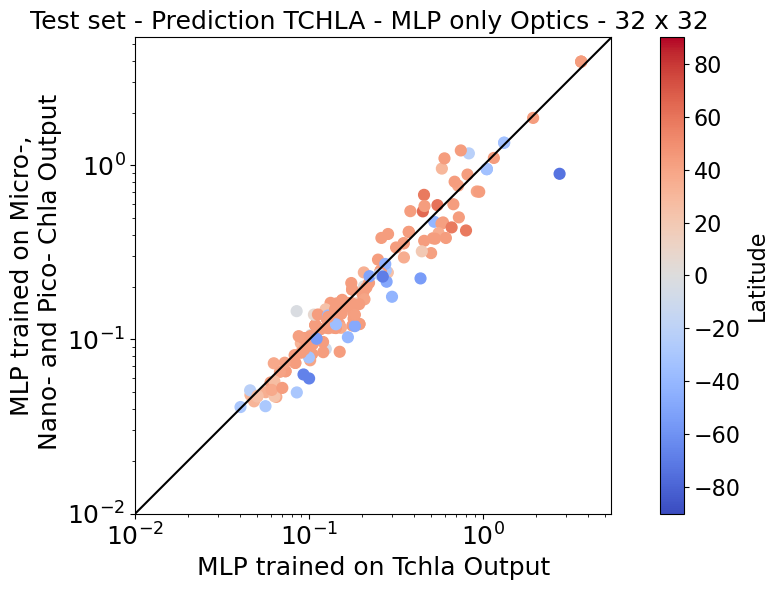

In [105]:
plot_score(prediction_tchla_32mlp1_pfts, prediction_32mlp1, 'Prediction TCHLA - MLP only Optics - 32 x 32', df_32_test_lat, output_link=False, axis_log=True,
               xlabel='MLP trained on Tchla Output', ylabel='MLP trained on Micro-,\n Nano- and Pico- Chla Output', PFTS=False, liste_med=None)

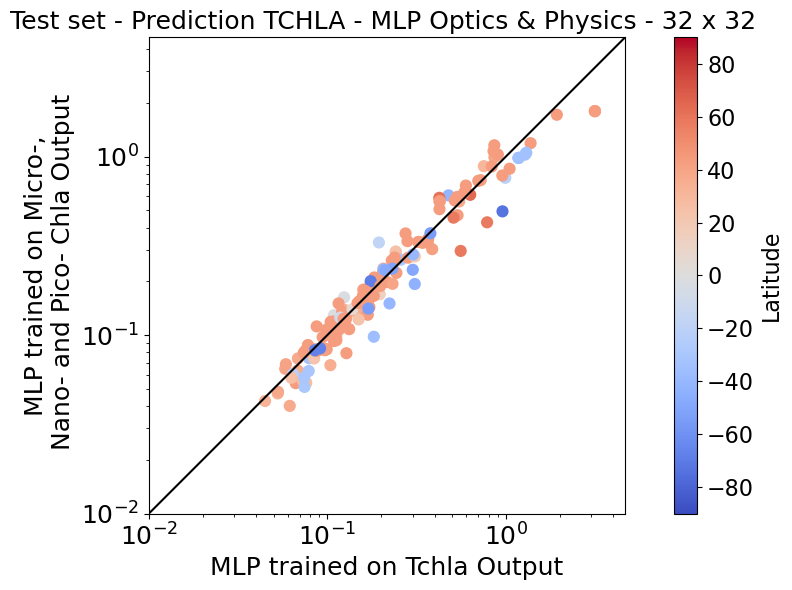

In [106]:
plot_score(prediction_tchla_32mlp2_pfts, prediction_32mlp2, 'Prediction TCHLA - MLP Optics & Physics - 32 x 32', df_32_test_lat, output_link=False, axis_log=True,
               xlabel='MLP trained on Tchla Output', ylabel='MLP trained on Micro-,\n Nano- and Pico- Chla Output', PFTS=False, liste_med=None)

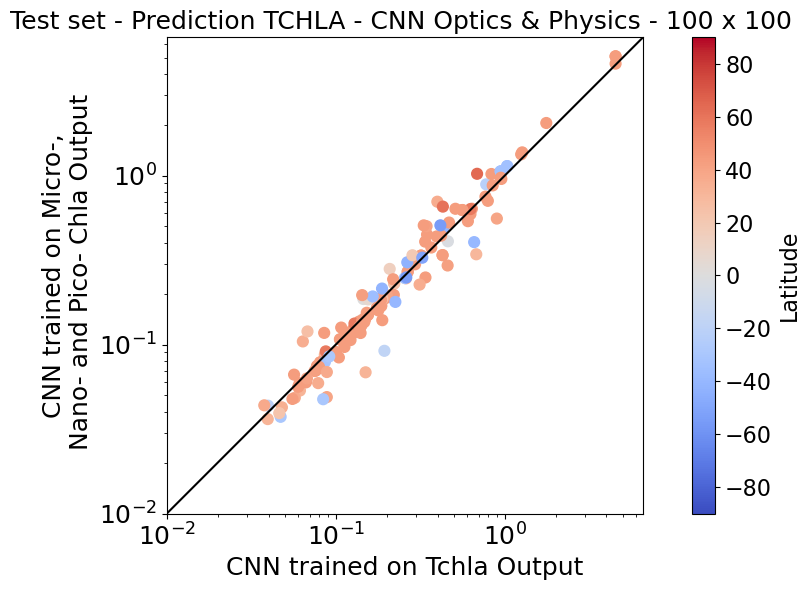

In [115]:
plot_score(prediction_tchla_100cnn2_pfts, prediction_100cnn2, 'Prediction TCHLA - CNN Optics & Physics - 100 x 100', df_100_test_lat, output_link=False, axis_log=True,
               xlabel='CNN trained on Tchla Output', ylabel='CNN trained on Micro-,\n Nano- and Pico- Chla Output', PFTS=False, liste_med=None)

KeyError: 'CNN (O&P)'

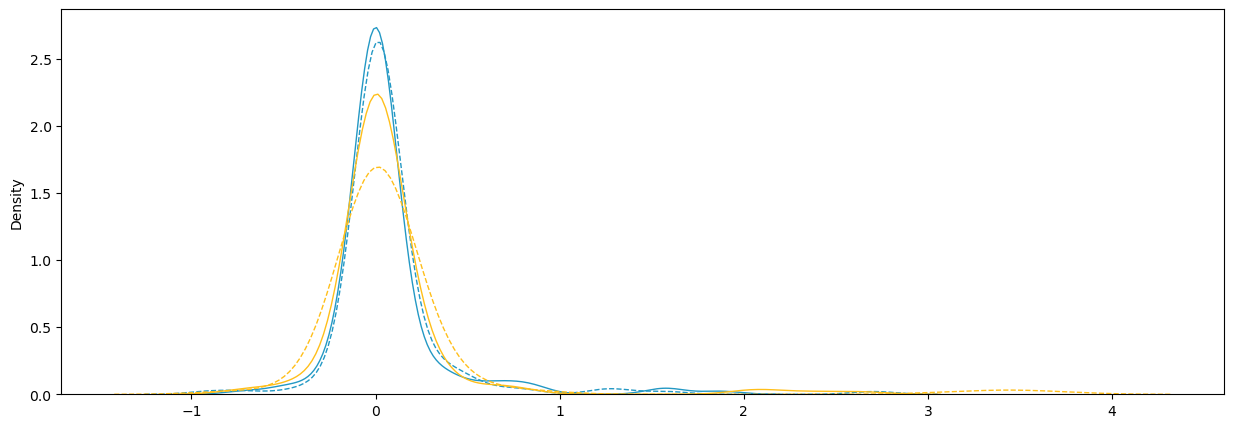

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Données d'erreurs (assure-toi qu'elles sont bien déjà des np.array)
errors = {
    'MLP (O)': diff_32mlp1,
    'MLP (O) trained on PFTS': diff_mlp1_pfts,
    'MLP (O&P)': diff_32mlp2,
    'MLP (O&P) trained on PFTS': diff_mlp2_pfts,
    'CNN (O&P)': diff_100cnn2,
    'CNN (O&P) trained on PFTS': diff_100cnn2_pfts,
}

colors = {
    'MLP (O)': '#2398c4',              
    'MLP (O) trained on PFTS': '#2398c4', 
    'MLP (O&P)': '#ffbf1a',            
    'MLP (O&P) trained on PFTS': '#ffbf1a' 
}

plt.figure(figsize=(15, 5))
all_vals = []

for model_name, data in errors.items():
    if isinstance(data, list):
        data = pd.Series(data)
    else:
        data = pd.Series(data.tolist())  # au cas où c'est un np.array

    all_vals.append(data)
    linestyle = '--' if 'trained on PFTS' in model_name else '-'
    sns.kdeplot(
        data.dropna(),
        color=colors[model_name],
        linewidth=1,
        linestyle=linestyle,
        label=model_name
    )

# Centrer l’axe x autour de 0
all_concat = pd.concat(all_vals)
max_abs = max(abs(all_concat.min()), abs(all_concat.max()))
plt.xlim(-max_abs, max_abs)

plt.xlabel("Error $(mg~m^{-3})$ = HPLC - Model Prediction", size=14)
plt.ylabel("Density", size=14)
plt.title("TChla CHLA - KDE of Prediction Errors", size=16)
plt.legend()
plt.grid(True)

# Enregistrer si besoin
#plt.savefig('./KDE_TChla_Comparison.png', dpi=300)

plt.show()


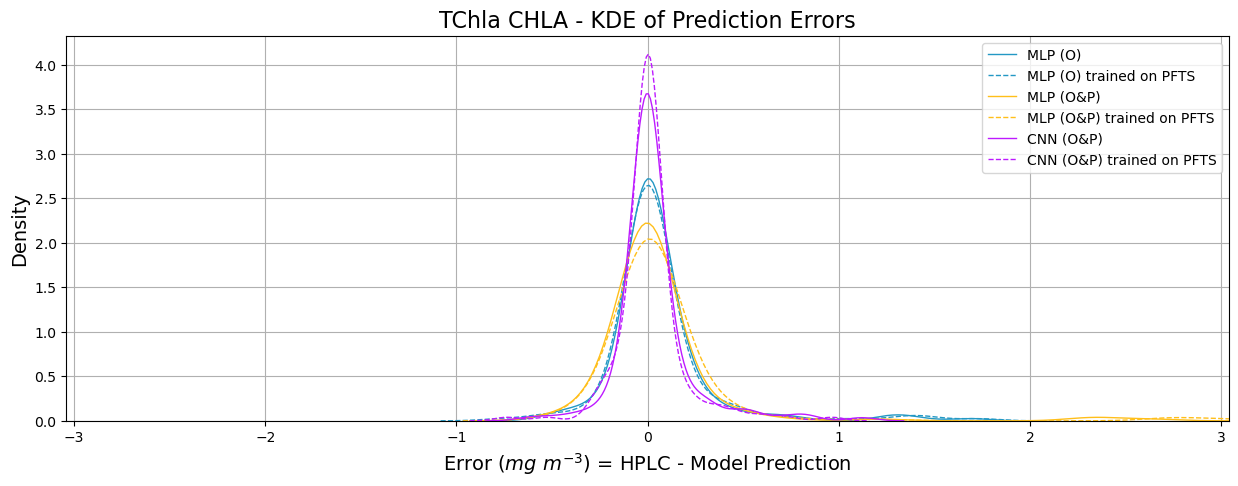

In [111]:
# Données d'erreurs (assure-toi qu'elles sont bien déjà des np.array)
errors = {
    'MLP (O)': diff_100mlp1,
    'MLP (O) trained on PFTS': diff_100mlp1_pfts,
    'MLP (O&P)': diff_100mlp2,
    'MLP (O&P) trained on PFTS': diff_100mlp2_pfts, 
    'CNN (O&P)': diff_100cnn2,
    'CNN (O&P) trained on PFTS': diff_100cnn2_pfts
}

colors = {
    'MLP (O)': '#2398c4',              
    'MLP (O) trained on PFTS': '#2398c4', 
    'MLP (O&P)': '#ffbf1a',            
    'MLP (O&P) trained on PFTS': '#ffbf1a', 
    'CNN (O&P)': '#bd1affff',            
    'CNN (O&P) trained on PFTS': '#bd1affff',
    
}

plt.figure(figsize=(15, 5))
all_vals = []

for model_name, data in errors.items():
    if isinstance(data, list):
        data = pd.Series(data)
    else:
        data = pd.Series(data.tolist())  # au cas où c'est un np.array

    all_vals.append(data)
    linestyle = '--' if 'trained on PFTS' in model_name else '-'
    sns.kdeplot(
        data.dropna(),
        color=colors[model_name],
        linewidth=1,
        linestyle=linestyle,
        label=model_name
    )

# Centrer l’axe x autour de 0
all_concat = pd.concat(all_vals)
max_abs = max(abs(all_concat.min()), abs(all_concat.max()))
plt.xlim(-max_abs, max_abs)

plt.xlabel("Error $(mg~m^{-3})$ = HPLC - Model Prediction", size=14)
plt.ylabel("Density", size=14)
plt.title("TChla CHLA - KDE of Prediction Errors", size=16)
plt.legend()
plt.grid(True)

# Enregistrer si besoin
#plt.savefig('./KDE_TChla_Comparison.png', dpi=300)

plt.show()


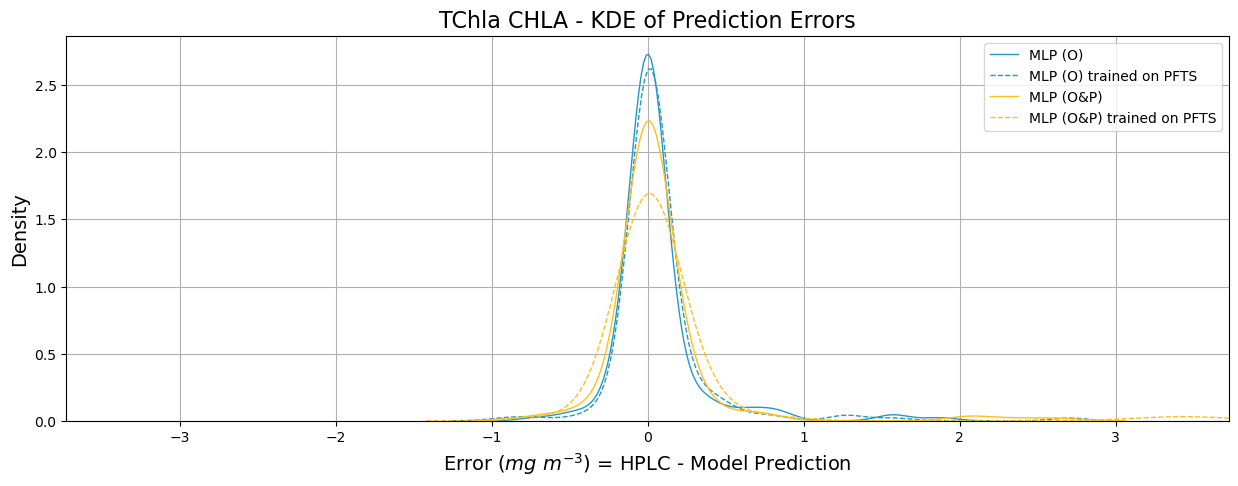

In [114]:
# Données d'erreurs (assure-toi qu'elles sont bien déjà des np.array)
errors = {
    'MLP (O)': diff_32mlp1,
    'MLP (O) trained on PFTS': diff_32mlp1_pfts,
    'MLP (O&P)': diff_32mlp2,
    'MLP (O&P) trained on PFTS': diff_32mlp2_pfts
}

colors = {
    'MLP (O)': '#2398c4',              
    'MLP (O) trained on PFTS': '#2398c4', 
    'MLP (O&P)': '#ffbf1a',            
    'MLP (O&P) trained on PFTS': '#ffbf1a', 
    'CNN (O&P)': '#bd1affff',            
    'CNN (O&P) trained on PFTS': '#bd1affff',
    
}

plt.figure(figsize=(15, 5))
all_vals = []

for model_name, data in errors.items():
    if isinstance(data, list):
        data = pd.Series(data)
    else:
        data = pd.Series(data.tolist())  # au cas où c'est un np.array

    all_vals.append(data)
    linestyle = '--' if 'trained on PFTS' in model_name else '-'
    sns.kdeplot(
        data.dropna(),
        color=colors[model_name],
        linewidth=1,
        linestyle=linestyle,
        label=model_name
    )

# Centrer l’axe x autour de 0
all_concat = pd.concat(all_vals)
max_abs = max(abs(all_concat.min()), abs(all_concat.max()))
plt.xlim(-max_abs, max_abs)

plt.xlabel("Error $(mg~m^{-3})$ = HPLC - Model Prediction", size=14)
plt.ylabel("Density", size=14)
plt.title("TChla CHLA - KDE of Prediction Errors", size=16)
plt.legend()
plt.grid(True)

# Enregistrer si besoin
#plt.savefig('./KDE_TChla_Comparison.png', dpi=300)

plt.show()
